

## Introduction

In this notebook, we aim to build a robust forecasting model that predicts daily retail store sales across multiple locations using a synthetic dataset covering 10 stores.

Each row in the dataset represents a single store's sales for a specific date, along with key external indicators such as promotional campaigns and holidays. This setup closely mirrors real-world retail forecasting scenarios, making it an ideal environment for experimenting with time series modeling techniques.

Unlike traditional per-store modeling, we adopt a **global modeling approach**—training a single machine learning model that can generalize patterns across all stores. This strategy enables the model to:

* Share statistical strength across stores,
* Learn from inter-store behavior patterns,
* Handle data sparsity more efficiently,
* And potentially improve forecasting accuracy and scalability.

We'll explore feature engineering techniques, visualize patterns and trends, and ultimately train a tree-based regression model (such as LightGBM) to forecast future sales. Our goal is to evaluate the model’s performance and generate actionable forecasts that account for promotions, holidays, and seasonality.

### 🔍 Problem Objective

> **Predict daily sales for each store using historical sales, calendar features, promotions, and holidays.**

This notebook will cover:

* Exploratory data analysis (EDA)
* Feature engineering (lagged values, rolling means, time components)
* Model training using LightGBM
* Performance evaluation using RMSE
* Generating future forecasts for each store



#### Tools

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

from lightgbm import early_stopping, log_evaluation



In [2]:
df = pd.read_csv('/kaggle/input/store-sales-dataset/store_sales.csv')

In [3]:
df

,date,store,sales,promo,holiday
0,2022-01-01,1,184.78,0,0
1,2022-01-02,1,192.62,0,0
2,2022-01-03,1,212.68,0,0
3,2022-01-04,1,249.58,1,0
4,2022-01-05,1,223.50,0,0
...,...,...,...,...,...
7295,2023-12-27,10,242.08,0,0
7296,2023-12-28,10,235.35,0,0
7297,2023-12-29,10,222.82,0,0
7298,2023-12-30,10,236.04,1,0


Sort data by store and date to maintain time series order

In [4]:
df = df.sort_values(by=['store', 'date']).reset_index(drop=True)

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
missing = df.isnull().sum()
print("Missing values:\n", missing)

Missing values:
 date       0
store      0
sales      0
promo      0
holiday    0
dtype: int64


In [7]:
df.describe()


,date,store,sales,promo,holiday
count,7300,7300.000000,7300.000000,7300.000000,7300.000000
mean,2022-12-31 12:00:00,5.500000,228.434571,0.202192,0.104110
min,2022-01-01 00:00:00,1.000000,160.710000,0.000000,0.000000
25%,2022-07-02 00:00:00,3.000000,209.217500,0.000000,0.000000
50%,2022-12-31 12:00:00,5.500000,226.795000,0.000000,0.000000
75%,2023-07-02 00:00:00,8.000000,245.590000,0.000000,0.000000
max,2023-12-31 00:00:00,10.000000,340.730000,1.000000,1.000000
std,NaN,2.872478,26.625636,0.401662,0.305424


Min-Max values for sales and Std, to asses and evalute the error when training the model.

In [8]:
df['sales'].min(), df['sales'].max(), df['sales'].std()

(160.71, 340.73, 26.62563608103697)

Create calendar-based features to get better insights when doing visualizations

In [9]:
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)


In [10]:
df.columns

Index(['date', 'store', 'sales', 'promo', 'holiday', 'day', 'month', 'year',
       'day_of_week', 'is_weekend'],
      dtype='object')

## EDA

Set a consistent style

In [11]:
sns.set_theme(style="whitegrid", context="notebook", palette="deep")
plt.rcParams.update({
    "figure.figsize": (14, 6),
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.titlepad": 15,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.alpha": 0.3,
    "lines.linewidth": 2,
})

/tmp/ipykernel_13/317803110.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.set_index('date').resample('M')['sales'].sum().reset_index()
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


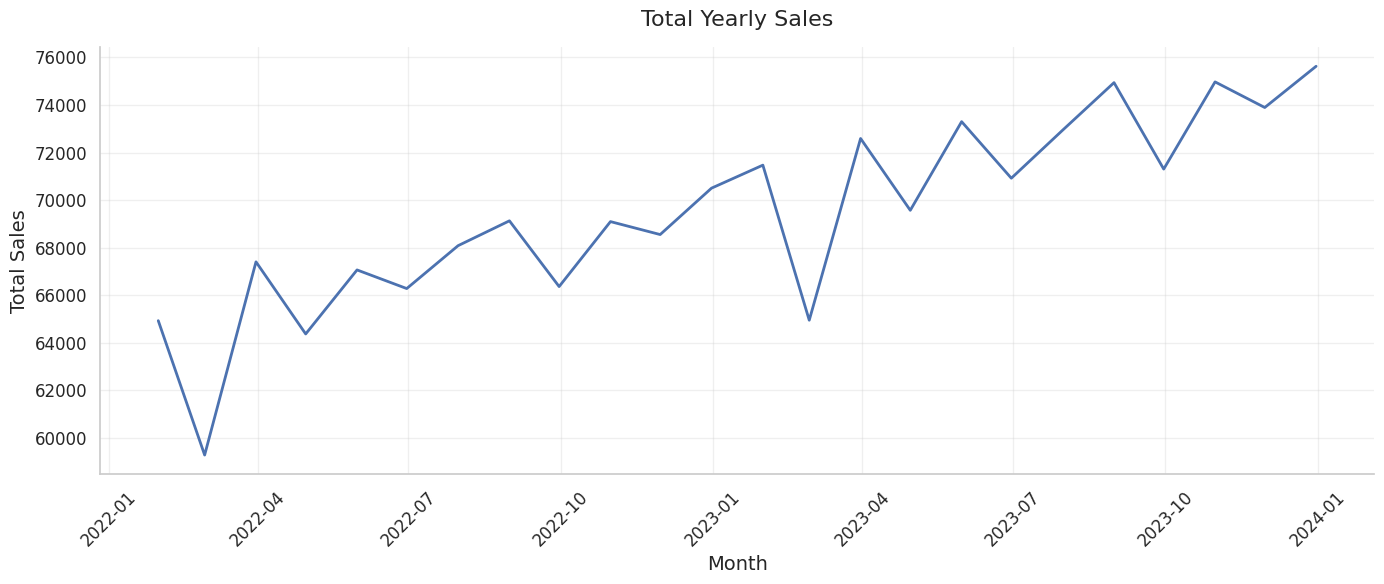

In [12]:
monthly_sales = df.set_index('date').resample('M')['sales'].sum().reset_index()
sns.lineplot(data=monthly_sales, x='date', y='sales')
plt.title("Total Yearly Sales")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




#### Key Insights

* **Upward Trend**: Sales steadily increased from early 2022 to late 2023.
* **Seasonality**: Dips in Feb/March and peaks in March, April, and late 2023 suggest seasonal patterns.
* **Year-over-Year Growth**: 2023 shows higher and more variable sales than 2022.
* **Stable Performance**: Overall, sales remain consistently strong without major volatility.


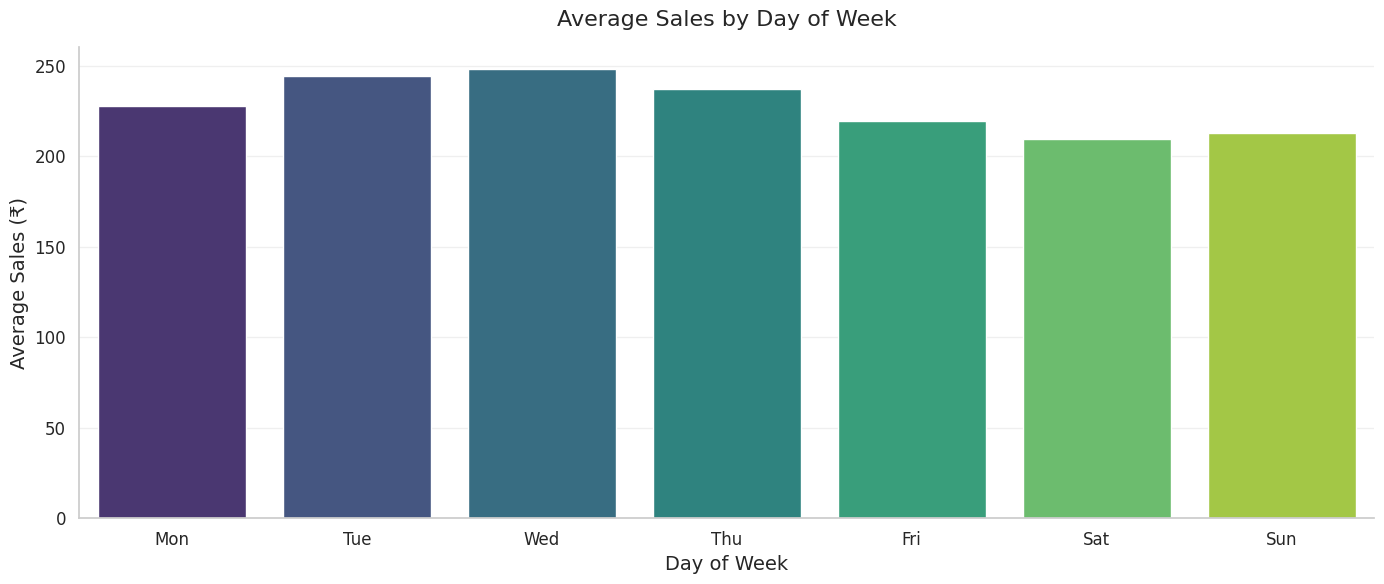

In [13]:
dow_avg = df.groupby('day_of_week')['sales'].mean().reset_index()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure()
sns.barplot(data=dow_avg, x='day_of_week', y='sales', palette='viridis')
plt.xticks(ticks=range(7), labels=dow_labels)
plt.title("Average Sales by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Sales (₹)")
plt.tight_layout()
plt.show()

#### Key Insights

* **Stable Performance**: Overall, sales remain consistently strong without major volatility.


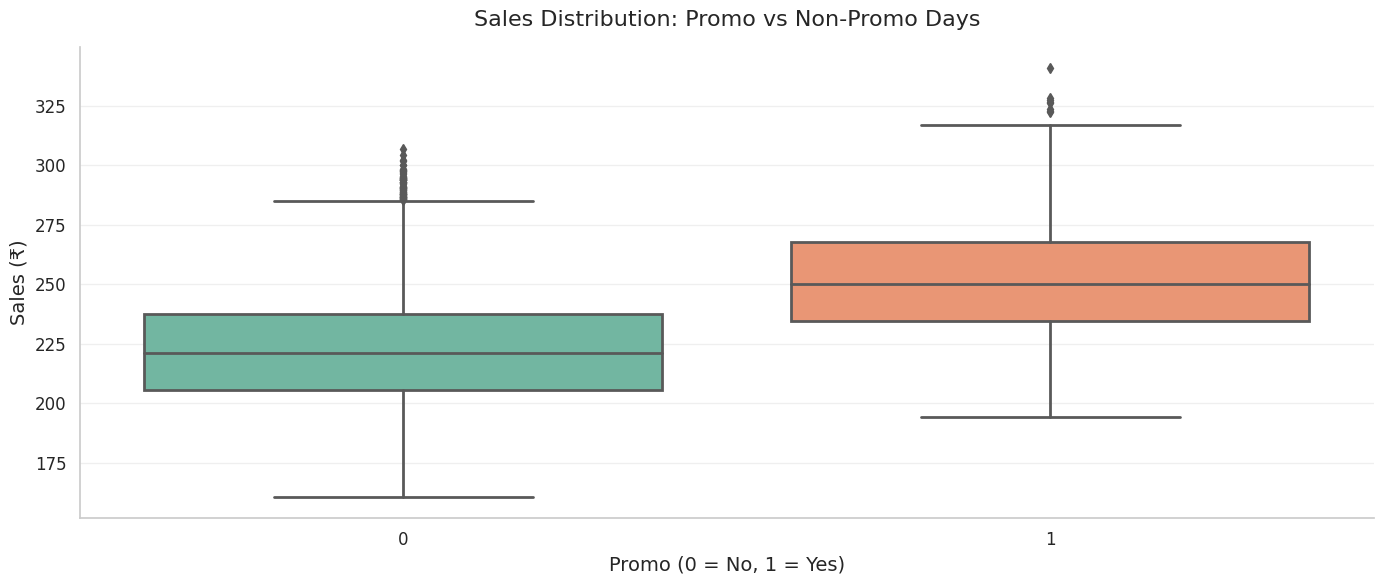

In [14]:
plt.figure()
sns.boxplot(data=df, x='promo', y='sales', palette='Set2')
plt.title("Sales Distribution: Promo vs Non-Promo Days")
plt.xlabel("Promo (0 = No, 1 = Yes)")
plt.ylabel("Sales (₹)")
plt.tight_layout()
plt.show()


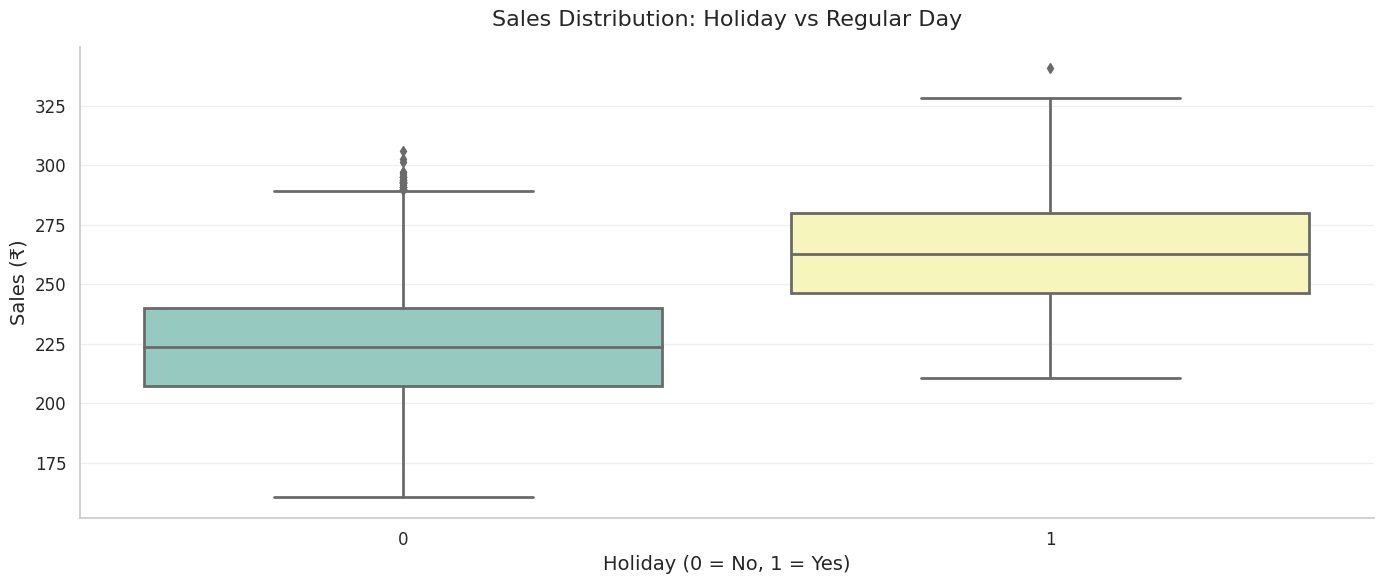

In [15]:
plt.figure()
sns.boxplot(data=df, x='holiday', y='sales', palette='Set3')
plt.title("Sales Distribution: Holiday vs Regular Day")
plt.xlabel("Holiday (0 = No, 1 = Yes)")
plt.ylabel("Sales (₹)")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_13/641341926.py:10: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


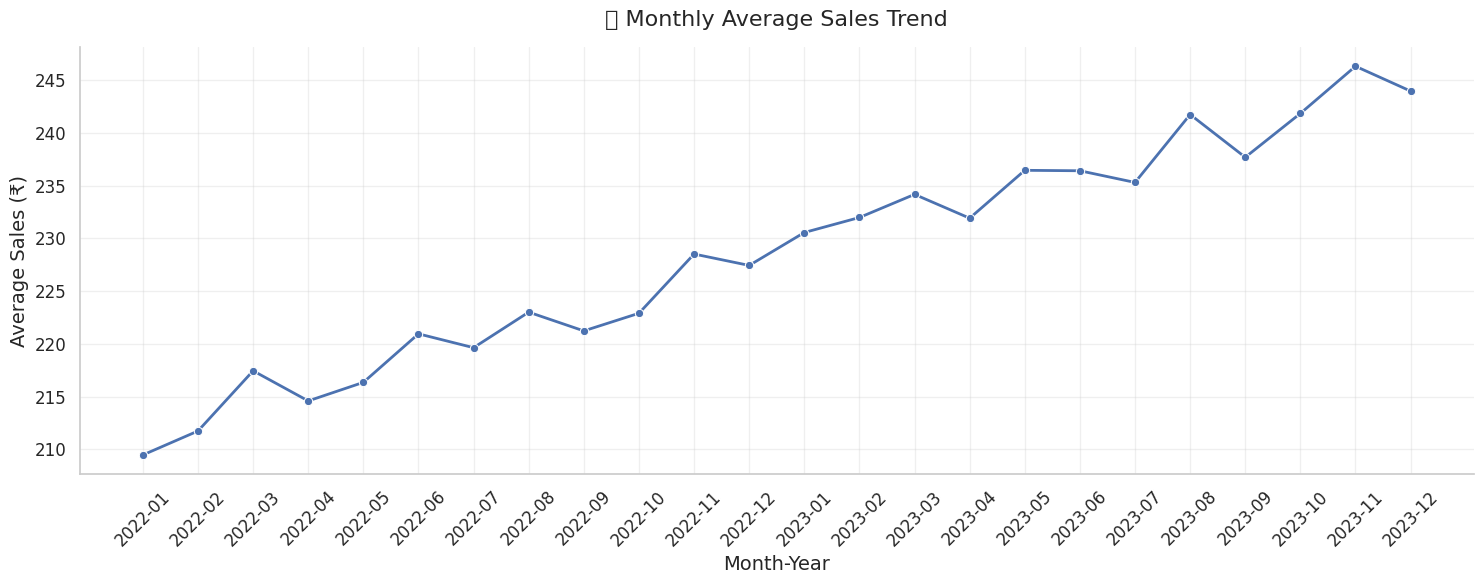

In [16]:
df['month_year'] = df['date'].dt.to_period('M').astype(str)
monthly_avg = df.groupby('month_year')['sales'].mean().reset_index()

plt.figure(figsize=(15,6))
sns.lineplot(data=monthly_avg, x='month_year', y='sales', marker='o')
plt.xticks(rotation=45)
plt.title("🗓️ Monthly Average Sales Trend")
plt.xlabel("Month-Year")
plt.ylabel("Average Sales (₹)")
plt.tight_layout()
plt.show()

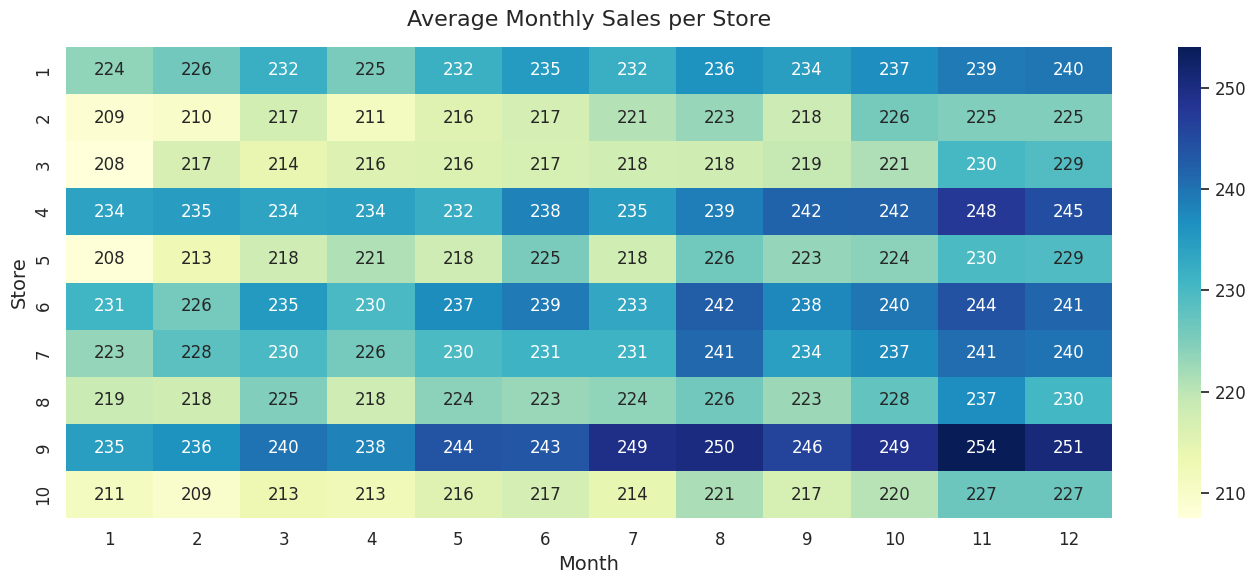

In [17]:
heatmap_data = df.copy()
heatmap_data['month'] = heatmap_data['date'].dt.month
heatmap_data['year'] = heatmap_data['date'].dt.year
pivot = heatmap_data.pivot_table(values='sales', index='store', columns='month', aggfunc='mean')

plt.figure()
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Average Monthly Sales per Store")
plt.xlabel("Month")
plt.ylabel("Store")
plt.tight_layout()
plt.show()

## Data preprocessing

In [18]:
# Lag features: previous day's and previous week's sales
df['sales_lag_1'] = df.groupby('store')['sales'].shift(1)
df['sales_lag_7'] = df.groupby('store')['sales'].shift(7)

# Rolling mean features
df['rolling_mean_3'] = df.groupby('store')['sales'].shift(1).rolling(3).mean()
df['rolling_mean_7'] = df.groupby('store')['sales'].shift(1).rolling(7).mean()


> We added **lag features** (`sales_lag_1`, `sales_lag_7`) and **rolling mean features** (`rolling_mean_3`, `rolling_mean_7`) to help the model learn from **past patterns** in sales.
>
> * **Lag features** capture the **previous day's** and **previous week's** sales, which often influence current sales.
> * **Rolling means** smooth out short-term fluctuations, helping to identify **recent sales trends**.
>
> These features improve forecasting by giving the model more context about past behavior.


In [19]:
df = df.dropna().reset_index(drop=True)

Define split date

In [20]:
split_date = pd.to_datetime('2023-10-01')
train = df[df['date'] < split_date]
valid = df[df['date'] >= split_date]


In [21]:
train.shape, valid.shape

((6310, 15), (920, 15))

In [22]:
feature_cols = [
    'store', 'promo', 'holiday', 'day', 'month', 'year', 'day_of_week', 'is_weekend',
    'sales_lag_1', 'sales_lag_7', 'rolling_mean_3', 'rolling_mean_7'
]

target_col = 'sales'


In [23]:
X_train = train[feature_cols]
y_train = train[target_col]

X_valid = valid[feature_cols]
y_valid = valid[target_col]

## Model Training

I will use LightGBM as it performs well in forecasting problems.

Create LightGBM datasets

In [24]:
train_set = lgb.Dataset(X_train, label=y_train, categorical_feature=['store'])
valid_set = lgb.Dataset(X_valid, label=y_valid, categorical_feature=['store'])

In [25]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.002,
    'verbosity': 1,
    'seed': 42,

}

In [26]:


model = lgb.train(
    params=params,
    train_set=train_set,
    num_boost_round=5000,
    valid_sets=[train_set, valid_set],
    callbacks=[
        log_evaluation(period=100)
    ]
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1092
[LightGBM] [Info] Number of data points in the train set: 6310, number of used features: 12
[LightGBM] [Info] Start training from score 226.347808
[100]	training's rmse: 22.1022	valid_1's rmse: 25.7628
[200]	training's rmse: 18.8172	valid_1's rmse: 22.5173
[300]	training's rmse: 16.1547	valid_1's rmse: 19.8889
[400]	training's rmse: 14.0115	valid_1's rmse: 17.755
[500]	training's rmse: 12.2919	valid_1's rmse: 15.97
[600]	training's rmse: 10.9233	valid_1's rmse: 14.5011
[700]	training's rmse: 9.82372	valid_1's rmse: 13.2947
[800]	training's rmse: 8.96107	valid_1's rmse: 12.2909
[900]	training's rmse: 8.26903	valid_1's rmse: 11.5253
[1000]	training's rmse: 7.71735	valid_1's rmse: 10.8964
[1100]	training's rmse: 7.2739	valid_1's rmse

We achieved training's rmse of **4.38267** and valid's rmse of **6.52322**, which are pretty low values since the min-max-std values are as followings (160.71, 340.73, 26.62563608103697)

## Evaluating

In [27]:
y_pred = model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'Validation RMSE: {rmse:.2f}')


Validation RMSE: 6.52


Create a plot for one store (e.g., store 1)

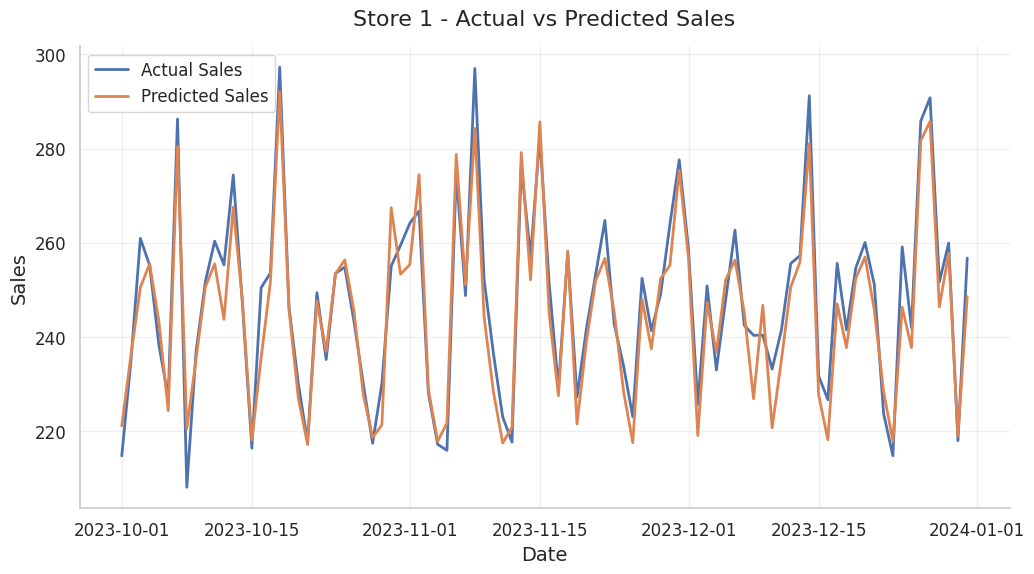

In [28]:
store_id = 1
store_valid = valid[valid['store'] == store_id].copy()
store_valid['predicted_sales'] = model.predict(store_valid[feature_cols])

plt.figure(figsize=(12, 6))
plt.plot(store_valid['date'], store_valid['sales'], label='Actual Sales')
plt.plot(store_valid['date'], store_valid['predicted_sales'], label='Predicted Sales')
plt.title(f'Store {store_id} - Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


There are no significant discrepancies between the actual sales and the predictions, indicating that our model generalizes well to unseen data.

Plot feature importance

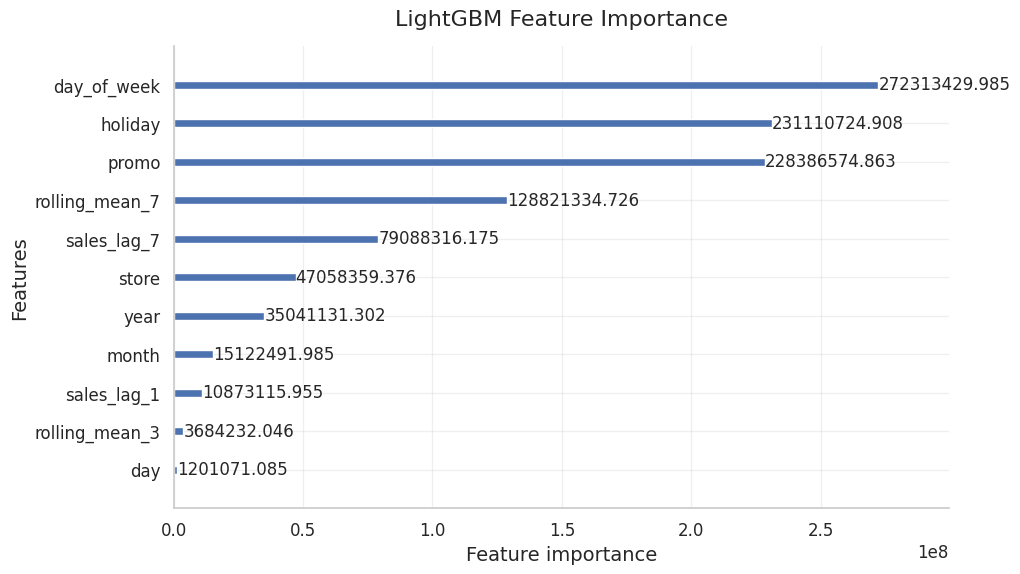

In [29]:
lgb.plot_importance(model, max_num_features=15, importance_type='gain', figsize=(10, 6))
plt.title("LightGBM Feature Importance")
plt.show()


**`day_of_week`, `holiday`, and `promo` are crucial features in LightGBM models because they capture key patterns in consumer behavior.**

* **`day_of_week`** reflects weekly sales cycles (e.g., higher weekend sales).
* **`holiday`** flags special days with unusual demand spikes or drops.
* **`promo`** directly influences customer purchasing decisions, often boosting sales.
  Together, these features help the model accurately learn and predict sales trends.


## Thank You